In [2]:

import timm
import warnings 
import albumentations as A
import torch.nn as nn
import pandas as pd
import numpy as np
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import pandas as pd
warnings.filterwarnings('ignore')
#set_seed(21, reproducible=True)

In [3]:
import torch
# Checking for GPU cuda and Device Optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'Using device: {device}')

Using device: cuda


In [4]:
train = pd.read_csv('Train.csv')

In [5]:
train.head()

,image_id_worm,worm_type,number_of_worms
0,id_0002ea6f15c7fa6f4c221783.jpg,pbw,51
1,id_0005ef295aafe6acc63587db.jpg,pbw,8
2,id_00084298dd030a500033ff78.jpg,NaN,0
3,id_00093f2c76f6488737325859.jpg,pbw,12
4,id_000b2e6c437c643f25d4a6c3.jpg,pbw,87


In [6]:
train.shape

(9900, 3)

In [7]:
train.isnull().sum()

image_id_worm         0
worm_type          3258
number_of_worms       0
dtype: int64

In [8]:
train["worm_type"] = train["worm_type"].replace(np.NaN , 'No worm')

In [9]:
new_values_train = {'pbw': 1, 'abw': 2, 'No worm':3}
train = train.replace({"worm_type":new_values_train})
train['worm_type'].value_counts()

1    4947
3    3258
2    1695
Name: worm_type, dtype: int64

In [10]:
test = pd.read_csv('Test.csv')
test.head()

,image_id_worm
0,id_00332970f80fa9a47a39516d.jpg
1,id_0035981bc3ae42eb5b57a317.jpg
2,id_005102f664b820f778291dee.jpg
3,id_0066456f5fb2cd858c69ab39.jpg
4,id_007159c1fa015ba6f394deeb.jpg


In [10]:
test.shape

(2803, 1)

In [30]:
images_boxes = pd.read_csv('images_bboxes.csv')
images_boxes.head()

,image_id,worm_type,geometry
0,id_8ada71185e18dc8838b4925b.jpg,pbw,"POLYGON ((2478.89 156.77, 2478.89 297.86, 2377..."
1,id_8ada71185e18dc8838b4925b.jpg,pbw,"POLYGON ((939.8199999999999 1221.46, 939.81999..."
2,id_8ada71185e18dc8838b4925b.jpg,abw,"POLYGON ((1559.7 1558.06, 1559.7 1966.3, 1129...."
3,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,POLYGON ((2090.216399557101 1537.2100674812148...
4,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,POLYGON ((2342.2568587778546 1676.304250464547...


In [25]:
images_boxes['geometry'].isnull().sum()

3258

In [26]:
images_boxes[images_boxes['geometry'].isnull()== True]

,image_id,worm_type,geometry
532,id_e45d64c9ab7a54e05b99ecdc.jpg,NaN,NaN
572,id_55c69d3402c27bbe37ac6683.jpg,NaN,NaN
620,id_1b746acec11fc62f95db2bcb.jpg,NaN,NaN
641,id_5d6a2c8811a294f14bcde464.jpg,NaN,NaN
651,id_4e75189682009c5574f66c90.jpg,NaN,NaN
...,...,...,...
9872,id_d19b17f61b6ddacfb3ae924c.jpg,NaN,NaN
9957,id_d6e8627c4cd8825494315661.jpg,NaN,NaN
10250,id_f5af7467096b0ab845d7dc08.jpg,NaN,NaN
10289,id_8c63e8a65494a10e6f08c48f.jpg,NaN,NaN


In [27]:
images_boxes.dropna(inplace=True)

In [28]:
def geometry_transform(data):
    size = len(data)
    L = np.array([x for x in data[:size - 2].replace('POLYGON ((', '').split(', ')])
    L1 = [x.split(' ') for x in L]
    return L1

def geo_to_XY_1(data):
    return data[0]

def geo_to_XY_2(data):
    if(len(data) > 1):
        return data[1]
    else:
        return '0'

def geo_to_XY_3(data):
    if(len(data) > 1):
        return data[2]
    else:
        return '0'

def geo_to_XY_4(data):
    if(len(data) > 1):
        return data[3]
    else:
        return '0'

def geo_to_XY_5(data):
    if(len(data) > 1):
        return data[4]
    else:
        return '0'

def X_to_col(data):
    return data[0]

def Y_to_col(data):
    return data[1]

images_boxes['geometry']=images_boxes['geometry'].astype(str)
images_boxes['geometry']=images_boxes['geometry'].apply(geometry_transform)
#new XY col
images_boxes['XY_1'] = images_boxes['geometry'].apply(geo_to_XY_1)
images_boxes['XY_2'] = images_boxes['geometry'].apply(geo_to_XY_2)
images_boxes['XY_3'] = images_boxes['geometry'].apply(geo_to_XY_3)
images_boxes['XY_4'] = images_boxes['geometry'].apply(geo_to_XY_4)
images_boxes['XY_5'] = images_boxes['geometry'].apply(geo_to_XY_5)

#X and Y
images_boxes['X_1'] = images_boxes['XY_1'].apply(X_to_col).astype('float64')
images_boxes['Y_1'] = images_boxes['XY_1'].apply(Y_to_col).astype('float64')

images_boxes['X_2'] = images_boxes['XY_2'].apply(X_to_col).astype('float64')
images_boxes['Y_2'] = images_boxes['XY_2'].apply(Y_to_col).astype('float64')

images_boxes['X_3'] = images_boxes['XY_3'].apply(X_to_col).astype('float64')
images_boxes['Y_3'] = images_boxes['XY_3'].apply(Y_to_col).astype('float64')

images_boxes['X_4'] = images_boxes['XY_4'].apply(X_to_col).astype('float64')
images_boxes['Y_4'] = images_boxes['XY_4'].apply(Y_to_col).astype('float64')

images_boxes['X_5'] = images_boxes['XY_5'].apply(X_to_col).astype('float64')
images_boxes['Y_5'] = images_boxes['XY_5'].apply(Y_to_col).astype('float64')

images_boxes['min_X'] = images_boxes[['X_1','X_2','X_3', 'X_4','X_5']].min(axis=1)
images_boxes['min_Y'] = images_boxes[['Y_1','Y_2','Y_3', 'Y_4','Y_5']].min(axis=1)
images_boxes['max_X'] = images_boxes[['X_1','X_2','X_3', 'X_4','X_5']].max(axis=1)
images_boxes['max_Y'] = images_boxes[['Y_1','Y_2','Y_3', 'Y_4','Y_5']].max(axis=1)

images_boxes.drop(columns=['XY_1','XY_2', 'XY_3', 'XY_4', 'XY_5', 'geometry','X_1','X_2', 'X_3', 'X_4', 'X_5','Y_1','Y_2', 'Y_3', 'Y_4', 'Y_5'], inplace=True)
#new_values_ib = {'pbw': 1, 'abw': 2}
#images_boxes = images_boxes.replace({"worm_type":new_values_ib})
images_boxes.head()


,image_id,worm_type,min_X,min_Y,max_X,max_Y
0,id_8ada71185e18dc8838b4925b.jpg,pbw,2377.970000,156.770000,2478.890000,297.860000
1,id_8ada71185e18dc8838b4925b.jpg,pbw,715.390000,1221.460000,939.820000,1319.680000
2,id_8ada71185e18dc8838b4925b.jpg,abw,1129.730000,1558.060000,1559.700000,1966.300000
3,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,1743.676282,1537.210067,2090.216400,1799.814857
4,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,2162.137567,1676.304250,2342.256859,1952.269926


In [17]:
images_boxes.head()

,image_id,worm_type,min_X,min_Y,max_X,max_Y
0,id_8ada71185e18dc8838b4925b.jpg,pbw,2377.970000,156.770000,2478.890000,297.860000
1,id_8ada71185e18dc8838b4925b.jpg,pbw,715.390000,1221.460000,939.820000,1319.680000
2,id_8ada71185e18dc8838b4925b.jpg,abw,1129.730000,1558.060000,1559.700000,1966.300000
3,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,1743.676282,1537.210067,2090.216400,1799.814857
4,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,2162.137567,1676.304250,2342.256859,1952.269926


In [29]:
images_boxes[['min_X']].value_counts()

min_X      
0.000000       95
1740.000000    56
1985.000000    55
1525.000000    53
1658.000000    52
               ..
1509.893050     1
1509.840000     1
1509.827589     1
1509.820000     1
7171.070000     1
Length: 82070, dtype: int64

In [9]:
#images_boxes.to_csv('images_boxes_w.csv', index=False)

In [7]:
images_boxes["worm_type"].value_counts()

pbw    127752
abw      9223
Name: worm_type, dtype: int64

In [8]:
images_boxes[['min_X','min_Y','max_X','max_Y',]][images_boxes['image_id'] == 'id_f11b846c5dc0d9b877850584.jpg']


,min_X,min_Y,max_X,max_Y
49,1347.0,2017.0,1521.0,2169.0
50,1144.0,2190.0,1575.0,2756.0
51,1333.0,823.0,1843.0,1192.0
52,694.0,2344.0,1128.0,2917.0
53,1342.0,2467.0,1834.0,2853.0
54,841.0,2158.0,1168.0,2652.0


In [12]:
import torchvision.transforms.functional as F
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [13]:
from torchvision.io import read_image
img = read_image('images/id_f11b846c5dc0d9b877850584.jpg')
print(img.size())

torch.Size([3, 4160, 3120])


In [14]:
# creating boxes
boxes = torch.tensor(images_boxes[['min_X','min_Y','max_X','max_Y']][images_boxes['image_id'] == 'id_f11b846c5dc0d9b877850584.jpg'].values)
print(boxes.size())
print(boxes)

torch.Size([6, 4])
tensor([[1347., 2017., 1521., 2169.],
        [1144., 2190., 1575., 2756.],
        [1333.,  823., 1843., 1192.],
        [ 694., 2344., 1128., 2917.],
        [1342., 2467., 1834., 2853.],
        [ 841., 2158., 1168., 2652.]], dtype=torch.float64)


In [28]:
L= images_boxes[['worm_type']][images_boxes['image_id'] == 'id_f11b846c5dc0d9b877850584.jpg'].to_numpy().tolist()
L1 = [x[0] for x in L]
L1

[1, 2, 2, 2, 2, 2]

In [23]:
# creating labels
labels = torch.tensor(labels)
print(labels.size())
print(labels)

torch.Size([6])
tensor([1, 2, 2, 2, 2, 2])


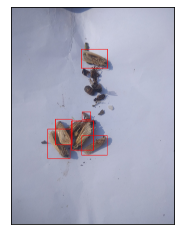

In [17]:
from torchvision.utils import draw_bounding_boxes

drawn_boxes = draw_bounding_boxes(img, boxes, colors="red", width=10)
show(drawn_boxes)